In [9]:
import numpy as np
import cv2 # Opencv
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [10]:
# Load the video
vidcap = cv2.VideoCapture('ball_tracking.mp4')

# Initialization of variables
success, image = vidcap.read()
count = 0
ball_data = []
time = []
id_frames = []

while success:
    # Get the red component of the image. An alternative is to convert the image to gray scale
    image_filtered = image[:,:,0] # Uses the red layer of the video frameto increase contrast
    # The following line may be used in cases where the ball is not red
    # image_filtered = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(image_filtered, cv2.HOUGH_GRADIENT, 6, 50, minRadius=40, maxRadius=60)
    # ensure at least some circles were found and the radius is greater than 0
    if circles is not None and circles[0,0,2] > 0:
        # Get the frame where the circle was identfied
        id_frames.append(vidcap.get(cv2.CAP_PROP_POS_FRAMES))
        # Store the time, position and diameter data
        ball_data.append(circles[0,0,:])
        time.append(vidcap.get(cv2.CAP_PROP_POS_MSEC))
    success, image = vidcap.read()
# Convert the arrays to numpy arrays
id_frames = np.asarray(id_frames)
ball_data = np.asarray(ball_data)
time = np.asarray(time)/1000 #seconds
time = time - time[0]


<ipython-input-11-c3930c00f175>:8: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image,(ball_data[frame,0], ball_data[frame,1]), ball_data[frame,2], (0, 255, 0), 15)


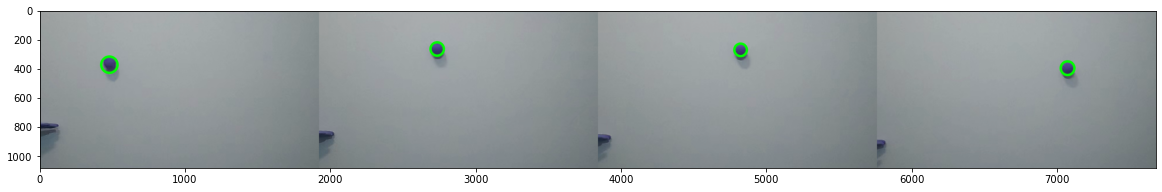

In [11]:
# Ilustrate the circle identification over the images
images = []
# Select frames to show
frames = [1,5,8,12]
for frame in frames:
    vidcap.set(cv2.CAP_PROP_POS_FRAMES,id_frames[frame]-1)
    success, image = vidcap.read()
    cv2.circle(image,(ball_data[frame,0], ball_data[frame,1]), ball_data[frame,2], (0, 255, 0), 15)
    images.append(image)

# Plot the images horizontally stacked
fig = plt.figure(figsize=(20,5))
plt.imshow(np.hstack(images))
    

In [12]:
# Calculate the pixel to m convertion
r_m = 0.03 # Ball radius in meters
r_px = np.mean(ball_data[:,2])
px_convertion = r_m/r_px

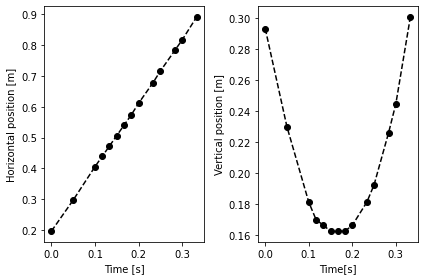

In [13]:
# Plot the horizontal and vertical positions
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(time,ball_data[:,0]*px_convertion,'ko--')
ax2.plot(time,ball_data[:,1]*px_convertion,'ko--')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Horizontal position [m]')
ax2.set_xlabel('Time[s]')
ax2.set_ylabel('Vertical position [m]')
fig.tight_layout()
# The parabola in the vertical position curve may look flipped, but it is related to the image axes definition. Please look the images above.

In [14]:
# Horizontal and vertical movement equation
def horizontal_position(t, a, b):
    return a*t + b

def vertical_position(t, a, b, c):
    return 0.5*a*t*t + b*t + c


---------------------------------------------
Acceleration of gravity : 9.78 m/s²
Initial vertical speed  : -1.63 m/s
Horizontal speed        : 2.08 m/s


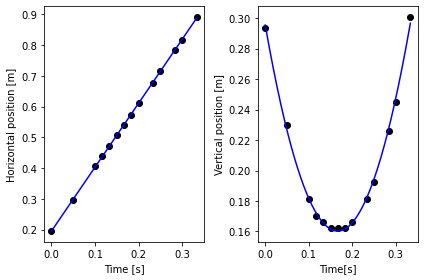

In [15]:

# Fit the curves
popt_vertical, pcov_vertical = curve_fit(vertical_position, time, ball_data[:,1]*px_convertion)
popt_horizontal, pcov_horizontal = curve_fit(horizontal_position, time, ball_data[:,0]*px_convertion)

# Plot the obtained curves
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(time,ball_data[:,0]*px_convertion,'ko')
ax1.plot(np.linspace(time[0],time[-1],1000), horizontal_position(np.linspace(time[0],time[-1],1000), popt_horizontal[0], popt_horizontal[1]),'b-')
ax2.plot(time,ball_data[:,1]*px_convertion,'ko')
ax2.plot(np.linspace(time[0],time[-1],1000), vertical_position(np.linspace(time[0],time[-1],1000), popt_vertical[0], popt_vertical[1], popt_vertical[2]),'b-')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Horizontal position [m]')
ax2.set_xlabel('Time[s]')
ax2.set_ylabel('Vertical position [m]')
fig.tight_layout()

# Displat the results
print('---------------------------------------------')
print(f'Acceleration of gravity : {popt_vertical[0]:.2f} m/s²')
print(f'Initial vertical speed  : {popt_vertical[1]:.2f} m/s')
print(f'Horizontal speed        : {popt_horizontal[0]:.2f} m/s')


